A hydrostatic, inviscid, adiabatic, and moist system in isentropic coordinates
==

In [1]:
from datetime import timedelta
import gridtools as gt
import numpy as np
import tasmania as taz

# For interactive plotting
from IPython import display
%matplotlib nbagg

/usr/local/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Load the computational grid and the initial state
--

In [2]:
grid, states = taz.load_netcdf_dataset('../tests/baseline_datasets/isentropic_moist.nc')
state = states[0]

Initialize the microphysical parameterizations
--

In [3]:
# The component calculating the microphysical sources/sinks 
# prescribed by the Kessler scheme; neglect the evaporation of
# rain in the subcloud layers
kessler = taz.Kessler(grid, pressure_on_interface_levels=True,
                      rain_evaporation_on=False, backend=gt.mode.NUMPY)

# The component performing the saturation adjustment 
# as prescribed by the Kessler scheme
saturation = taz.SaturationAdjustmentKessler(grid, pressure_on_interface_levels=True,
                                             backend=gt.mode.NUMPY)

Instantiate the dynamical core
--

In [4]:
# Adopt the flux form of the forward Euler time integration method,
# with the horizontal numerical fluxes calculated via the upwind scheme;
# neglect the sedimentation of rain
dycore = taz.IsentropicDynamicalCore(grid, moist_on=True,
                                     time_integration_scheme='forward_euler',
                                     horizontal_flux_scheme='upwind',
                                     horizontal_boundary_type='relaxed',
                                     smooth_on=True, smooth_type='first_order',
                                     smooth_coeff=0.20, smooth_at_every_stage=True,
                                     adiabatic_flow=True, sedimentation_on=False,
                                     backend=gt.mode.NUMPY, dtype=np.float64)

Create a monitor for interactive visualization
---------------------------------------------------------------

In [5]:
# The artist generating the left subplot
subplot1 = taz.Plot2d(grid, plot_function=taz.make_contourf_xz, 
                      field_to_plot='x_velocity_at_u_locations', level=0,
                      plot_properties={'fontsize': 16, 
                                       'title_left': '$x$-velocity [m s$^{-1}$]',
                                       'x_label': '$x$ [km]', 'x_lim': [0, 500],
                                       'y_label': '$z$ [km]', 'y_lim': [0, 14]},
                      plot_function_kwargs={'fontsize': 16, 
                                            'x_factor': 1e-3, 'z_factor': 1e-3,
                                            'cmap_name': 'BuRd', 'cbar_on': True, 
                                            'cbar_levels': 18, 'cbar_ticks_step': 2, 
                                            'cbar_center': 15, 'cbar_half_width': 8.5,
                                            'cbar_orientation': 'horizontal'})

# The artist generating the right subplot
subplot2 = taz.Plot2d(grid, plot_function=taz.make_contourf_xz, 
                      field_to_plot='mass_fraction_of_cloud_liquid_water_in_air', level=0,
                      plot_properties={'fontsize': 16, 
                                       'title_left': 'Cloud liquid water [g kg$^{-1}$]',
                                       'x_label': '$x$ [km]', 'x_lim': [0, 500],
                                       'y_lim': [0, 14], 'yaxis_visible': False},
                      plot_function_kwargs={'fontsize': 16, 
                                            'x_factor': 1e-3, 'z_factor': 1e-3,
                                            'field_factor': 1e3,
                                            'cmap_name': 'Blues', 'cbar_on': True, 
                                            'cbar_levels': 18, 'cbar_ticks_step': 4, 
                                            'cbar_orientation': 'horizontal'})

# The monitor encompassing and coordinating the two artists
monitor = taz.SubplotsAssembler(nrows=1, ncols=2, artists=(subplot1, subplot2), 
                                interactive=False, figsize=(12, 7), fontsize=16, 
                                tight_layout=True)

Run the simulation
---------------------------

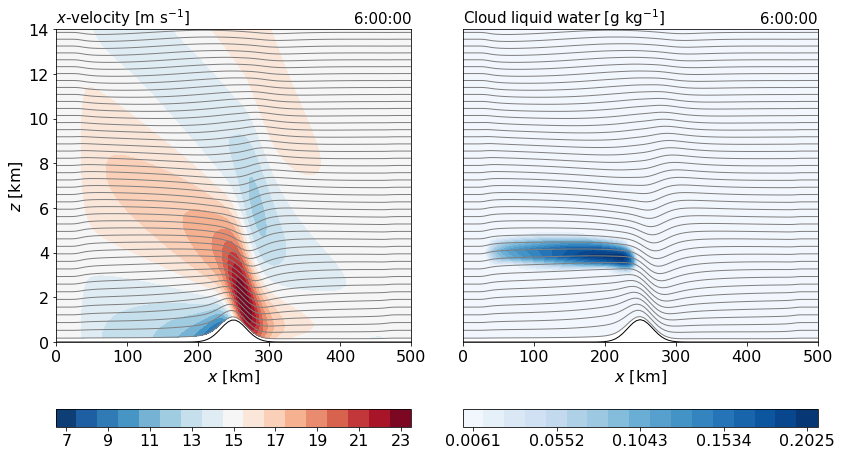

Simulation successfully completed. HOORAY!


In [6]:
# Simulation settings
timestep = timedelta(seconds=10)
niter    = 2160

for i in range(niter):
    # Update the (time-dependent) topography
    dycore.update_topography((i+1)*timestep)
    
    # Calculate the microphysical tendencies
    tendencies, _ = kessler(state)
    
    # Step the solution
    state_new = dycore(state, tendencies, timestep)
    state.update(state_new)
    
    # Perform the saturation adjustment
    state_new = saturation(state)
    state.update(state_new)

    if (i+1) % 60 == 0:
        # Plot the solution
        subplot1.plot_properties['title_right'] = str((i+1)*timestep)
        subplot2.plot_properties['title_right'] = str((i+1)*timestep)
        fig = monitor.store((state, state), show=False)
        display.clear_output(wait=True)
        display.display(fig)
        
print('Simulation successfully completed. HOORAY!')

Results validation
--

In [7]:
for name in state.keys():
    if name != 'time':
        assert np.allclose(states[-1][name].values, state[name].values), \
               'Variable {} not validated.'.format(name)
print('Results validated. HOORAY! HOORAY!')

Results validated. HOORAY! HOORAY!
